In [29]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

#import seaborn as sns
#sns.set(style='ticks')

params = {'legend.fontsize': 'x-large',
         'figure.figsize': (15,5),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
%matplotlib inline

pd.options.mode.chained_assignment = None

In [40]:
#open the csv file for miles
filename = 'MiniMiles.csv'

#get the data
mdata = pd.read_csv(filename,skiprows=0)

###Convert Datetime to format
mdata['dtime'] = pd.to_datetime(mdata.dtime,format='%Y-%m-%d %H:%M:%S')
mdata['miles_int'] = 0

nentries = len(mdata)
Miles0 = mdata.miles.min()
for i in range(1,nentries):
    mdata.miles_int.loc[i] = mdata.miles.loc[i]-mdata.miles.loc[i-1]

#mdata['mymiles'] = mdata.miles -mdata.miles[0]
#mdata['dTime'] = mdata.Data + ' ' 

def add_miles(month,day,year,hour,minute, miles):
    newdate = datetime(year, month, day, hour, minute)
    nentries = len(mdata)
    diff = miles - mdata.miles.loc[nentries-1]
    if diff < 0:
        return
    
    mdata.loc[nentries] =[pd.to_datetime(newdate),miles,diff]
    return;

def add_gas(month,day,year,hour,minute, gallons, price):
    newdate = datetime(year, month, day, hour, minute)
    nentries = len(gdata)
        
    gdata.loc[nentries] =[pd.to_datetime(newdate),gallons, price]
    return;

def save_miles():
    mdata.to_csv('MiniMiles.csv',sep=',',encoding='utf-8', index=False,columns=['dtime','miles'])
    return;

def save_gas():
    gdata.to_csv('GasRefills.csv',sep=',',encoding='utf-8', index=False,columns=['gtime','gallons','price'])
    return;

# Add miles or gas data

In [10]:
#add_miles(month, day, year, hour, minutes, miles)
#add_miles(12,20,2017,19,30,4358)

,dtime,miles,miles_int
0,2017-12-18 18:00:01,4279,0
1,2017-12-18 21:00:00,4291,12
2,2017-12-19 20:00:00,4325,34
3,2017-12-20 18:45:00,4355,30
4,2017-12-20 19:30:00,4358,3


In [ ]:
#add_gas(month, day, year,hour, minutes, gallons, price)

## Save the csv data file

In [36]:
save_miles()

In [39]:
save_gas()

# Resample the date by day

Resample the data by day 'D', get the total number of miles driven per day, and cumulative miles driven.

In [4]:
#Get the Series data with time as an index
dt1 = pd.Series(mdata.miles_int.tolist(), index=mdata.dtime)
dt2 = pd.Series(mdata.miles.tolist(), index=mdata.dtime)

#resample the data by day, later it can be by week, or business day
max_m = dt2.resample('D').max();
mpday = dt1.resample('D').sum();

#merge the series into a dataframe
mpd1 = pd.DataFrame(data=mpday.values,columns=['mpd'])
mpd2 = pd.DataFrame(data=mpday.index,columns=['dtime'])
max1 = pd.DataFrame(data=max_m.values,columns=['max_miles'])
mpdt = pd.merge(mpd2,mpd1,left_index=True, right_index=True);

mpd = mpdt.merge(max1,left_index=True,right_index=True)

# Plot the miles vs time

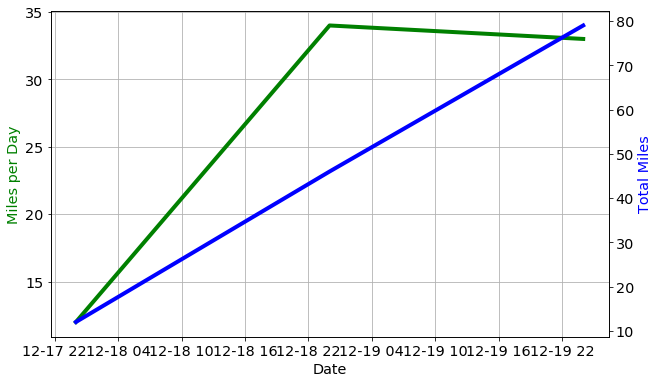

In [27]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(mpd.dtime, mpd.mpd,'g-',linewidth=4)
ax2.plot(mpd.dtime, mpd.max_miles-Miles0, 'b-',linewidth=4)


ax1.set_xlabel('Date')
ax1.set_ylabel('Miles per Day', color ='g')
ax2.set_ylabel('Total Miles', color='b')
ax1.grid(True)
#ax2.semilogy(True)
#ax1.semilogy(True)
plt.show()
plt.rcParams['figure.figsize']=10,6


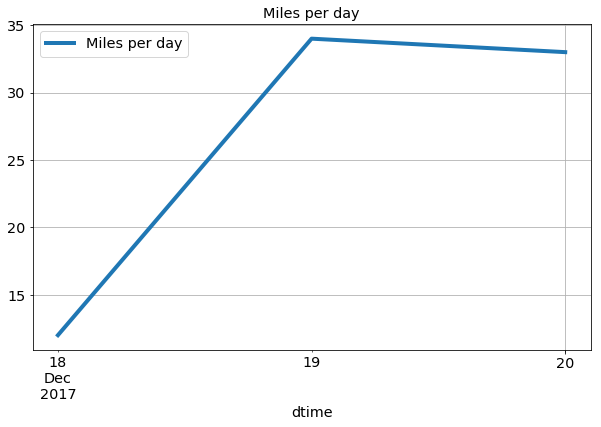

In [21]:
fig = plt.figure(1)
mpd.plot(x='dtime',y='mpd',figsize=(10,6),grid=True,kind='line',
         label='Miles per day',linewidth=4,title='Miles per day')

In [83]:
#Plot miles per trip
#fig = plt.figure(1)
#mdata[mdata.miles_int >0].plot(x='dtime',y='miles_int',figsize=(15,10),grid=True,label='Miles per trip')

In [38]:
gdata = pd.DataFrame(columns=['gtime','gallons','price'])